In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/augmented-dataset-csv/augmented_dataset.csv


In [22]:
import pandas as pd

In [23]:
# let's store the csv dataset into a DataFrame and have a look at it
# Ссылка на скачивание данных в формате CSV
csv_data_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vT3Wns_gLiMDfacVgF-x4suNvnAFmgibVkrsizkKqwcVFGSYAVOVnJsoV7gm3jguw/pub?gid=681978523&single=true&output=csv"

# Загрузка данных в DataFrame
data = pd.read_csv(csv_data_url)

# Просмотр первых нескольких строк данных
print(data.head())

   Unnamed: 0                                       problem_text  \
0           0  To prove that the sum of the numbers of the ex...   
1           1  ( b) Will the statement of the previous challe...   
2           2  The quadratic three-member graph with the coef...   
3           3  Can you draw on the surface of Rubik's cube a ...   
4           4  Dima, who came from Vrunlandia, said that ther...   

           topic  
0  number_theory  
1  number_theory  
2       polynoms  
3  combinatorics  
4         graphs  


In [24]:
len(data)

5273

In [25]:
# Lets count duplicated entries in the problem_text column
# 'problem_text' имя столбца, в котором нужно найти дубликаты
duplicates = data.duplicated(subset=['problem_text'], keep=False)

# Считаем количество дубликатов
num_duplicates = duplicates.sum()

# Выводим количество дубликатов
print(f'Количество дубликатов в столбце "problem_text": {num_duplicates}')


Количество дубликатов в столбце "problem_text": 1720


In [26]:
# We'll leave the first entries and we'll drop the duplicates 
# Удаляем дубликаты, оставляя только первые вхождения
data_no_dupes = data.drop_duplicates(subset=['problem_text'], keep='first')

# Перезаписываем индексы после удаления дубликатов
data_no_dupes.reset_index(drop=True, inplace=True)


In [27]:
# We need to check the results. We expect 0 duplicated entries in the column we cleaned
#смотрим, как удалили 
duplicates = data_no_dupes.duplicated(subset=['problem_text'], keep=False)
num_duplicates = duplicates.sum()
print(f'Количество дубликатов в столбце "problem_text": {num_duplicates}')

Количество дубликатов в столбце "problem_text": 0


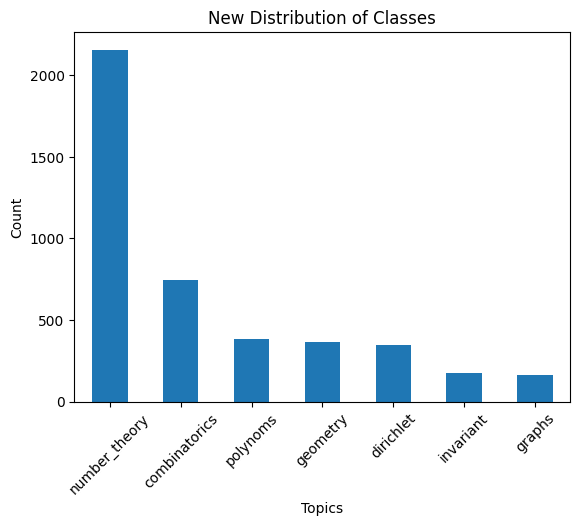

In [28]:
# A quick visual aid to check the distribution over classes
# распрелеление по классам
import matplotlib.pyplot as plt

class_counts = data_no_dupes['topic'].value_counts()
class_counts.plot(kind='bar')
plt.title('New Distribution of Classes')
plt.xlabel('Topics')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

In [29]:
class_counts

topic
number_theory    2156
combinatorics     743
polynoms          380
geometry          364
dirichlet         344
invariant         172
graphs            160
Name: count, dtype: int64

In [30]:
# We'll need to augment the datset to balance the distribution 
# but beforehand we should split the data set into test train val sets 
#разобьем на test train val
from sklearn.model_selection import train_test_split

# Разделение датасета
train, test_val = train_test_split(data_no_dupes, test_size=0.4, random_state=42)
val, test = train_test_split(test_val, test_size=0.5, random_state=42)

# сохраним
train.to_csv('train.csv', index=False)
val.to_csv('val.csv', index=False)
test.to_csv('test.csv', index=False)


In [31]:
!ls -la /kaggle/working

total 1084
drwxr-xr-x 3 root root   4096 May  4 20:23 .
drwxr-xr-x 5 root root   4096 May  4 20:23 ..
drwxr-xr-x 2 root root   4096 May  4 20:23 .virtual_documents
-rw-r--r-- 1 root root 221816 May  4 20:24 test.csv
-rw-r--r-- 1 root root 645934 May  4 20:24 train.csv
-rw-r--r-- 1 root root 221225 May  4 20:24 val.csv


In [32]:
train.head()

,Unnamed: 0,problem_text,topic
2659,3017,What numbers should be put instead of stars to...,number_theory
1613,1745,"In the town of Little 15 phones, can they be w...",combinatorics
835,868,Prove that the number is divided by 2k and not...,number_theory
1405,1497,What is the greatest amount of (a) okay; (b) i...,invariant
4026,4823,"Are there such natural numbers a, b and c that...",polynoms


In [33]:
# We'll augment the train set with https://github.com/makcedward/nlpaug 
# будем выравнивать датасет по классам с помощью https://github.com/makcedward/nlpaug 
!pip install nlpaug numpy matplotlib python-dotenv


^C
ERROR: Operation cancelled by user


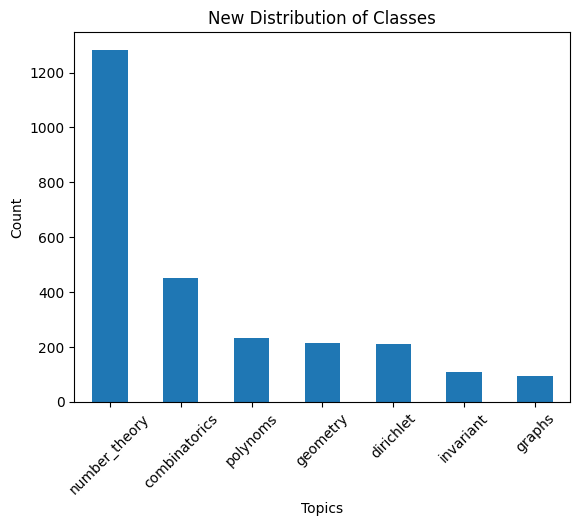

In [34]:
# Lets see how the classes are represeted in our train set
import matplotlib.pyplot as plt

class_counts = train['topic'].value_counts()
class_counts.plot(kind='bar')
plt.title('New Distribution of Classes')
plt.xlabel('Topics')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

In [35]:
class_counts

topic
number_theory    1284
combinatorics     451
polynoms          231
geometry          212
dirichlet         211
invariant         109
graphs             93
Name: count, dtype: int64

In [36]:
import torch
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


In [37]:
# for Kaggle & Bert tokenizer
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [38]:
!nvidia-smi

Sat May  4 20:24:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0              26W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [39]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 

print('ok')

ok


In [41]:
# actual augmenting happens here

import nlpaug.augmenter.word as naw
import pandas as pd
import torch
torch.set_printoptions(profile="full")

torch.set_num_threads(1) # I had to do that due to some obscure mistake


# Инициализация аугментатора BERT
# aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute", device='cpu')
aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute", device='cuda')

# Определение максимального количества примеров в классе
max_samples = train['topic'].value_counts().max()

# Создание пустого DataFrame для аугментированных данных
augmented_data = pd.DataFrame(columns=train.columns)

# Аугментация данных
for topic in train['topic'].unique():
    # Вычисление необходимого количества аугментаций для класса
    current_count = train[train['topic'] == topic].shape[0]
    augment_count = max_samples - current_count
    
    if augment_count > 0:
        # Выборка случайных примеров для аугментации
        sample = train[train['topic'] == topic].sample(n=augment_count, replace=True)
        
        # Применение аугментации
        sample['problem_text'] = sample['problem_text'].apply(lambda x: aug.augment(x))
        
        # Добавление аугментированных примеров в датасет
        augmented_data = pd.concat([augmented_data, sample])

# Объединение аугментированных данных с исходным обучающим датасетом
train_augmented = pd.concat([train, augmented_data])

# Перемешиваем данные
train_augmented = train_augmented.sample(frac=1).reset_index(drop=True)

# Сохраняем аугментированный датасет в новый CSV-файл
train_augmented.to_csv('train_augmented.csv', index=False)


In [47]:
len(train_augmented)

8988

In [42]:
!ls -la /kaggle/working

total 3744
drwxr-xr-x 3 root root    4096 May  4 20:38 .
drwxr-xr-x 5 root root    4096 May  4 20:23 ..
drwxr-xr-x 2 root root    4096 May  4 20:23 .virtual_documents
-rw-r--r-- 1 root root  221816 May  4 20:24 test.csv
-rw-r--r-- 1 root root  645934 May  4 20:24 train.csv
-rw-r--r-- 1 root root 2721438 May  4 20:38 train_augmented.csv
-rw-r--r-- 1 root root  221225 May  4 20:24 val.csv


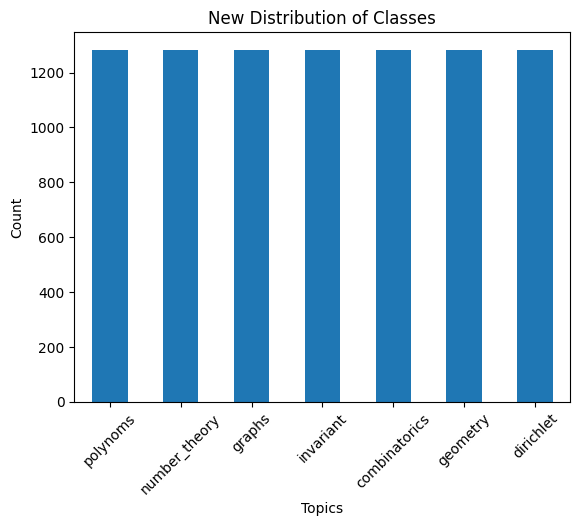

In [43]:
# Lets marvel at the augmeted train set
import matplotlib.pyplot as plt

class_counts = train_augmented['topic'].value_counts()
class_counts.plot(kind='bar')
plt.title('New Distribution of Classes')
plt.xlabel('Topics')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

In [44]:
# There could be some duplicates creeping in after the augmetation
duplicates = train_augmented.duplicated(subset=['problem_text'], keep=False)

num_duplicates = duplicates.sum()

print(f'Количество дубликатов в столбце "problem_text": {num_duplicates}')

Количество дубликатов в столбце "problem_text": 5


In [48]:
duplicates

0       False
1       False
2       False
3       False
4       False
        ...  
8983    False
8984    False
8985    False
8986    False
8987    False
Length: 8988, dtype: bool

In [ ]:
# Downloading neccessities

import os
from IPython.display import FileLink

# Путь к файлу на вашем ноутбуке Kaggle
file_path = 'train_augmented.csv'

# Проверяем, существует ли файл
if os.path.isfile(file_path):
    # Создаем ссылку для скачивания
    download_link = FileLink(file_path, result_html_prefix="Click here to download: ")
    display(download_link)
else:
    print("Файл не найден")

In [ ]:
import os
from IPython.display import FileLink

# Путь к файлу на вашем ноутбуке Kaggle
file_path = 'val.csv'

# Проверяем, существует ли файл
if os.path.isfile(file_path):
    # Создаем ссылку для скачивания
    download_link = FileLink(file_path, result_html_prefix="Click here to download: ")
    display(download_link)
else:
    print("Файл не найден")

In [ ]:
import os
from IPython.display import FileLink

# Путь к файлу на вашем ноутбуке Kaggle
file_path = 'test.csv'

# Проверяем, существует ли файл
if os.path.isfile(file_path):
    # Создаем ссылку для скачивания
    download_link = FileLink(file_path, result_html_prefix="Click here to download: ")
    display(download_link)
else:
    print("Файл не найден")

In [45]:
train_augmented['topic'].value_counts()


topic
polynoms         1284
number_theory    1284
graphs           1284
invariant        1284
combinatorics    1284
geometry         1284
dirichlet        1284
Name: count, dtype: int64

In [46]:
!pip install transformers


In [49]:
from transformers import AutoTokenizer

# Загрузка токенизатора
tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

# Изменённая функция токенизации
def tokenize_function(text):
    return tokenizer(text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")

# Применяем функцию токенизации ко всему столбцу 'problem_text'
train_dataset = train_augmented['problem_text'].apply(tokenize_function)
test_dataset = test['problem_text'].apply(tokenize_function)
val_dataset = val['problem_text'].apply(tokenize_function)

# Проверяем первый элемент токенизированных данных
print(train_dataset.iloc[0])


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

{'input_ids': tensor([[   101,  33826,  27891,  11100,  17136,  10728,    239,  92816,  16715,
          13334,  14011,  10966,  10700,  10918,  18721,   7168,    232,  10623,
          12371,    259,  18303,  12054,  16286,    271,  10626,  12843,    234,
          17136,  10837,  10888,  10672,  10967, 102117,  10725,  10880,  33162,
          40666,    132,  10667,  14607,  11781,  10626,  12843,    234,    128,
            240,  12099,  10037,  11857,  32973,  17533,  10968,  71129,  16010,
          10725,  10880,  10966,  10623,  12371,    259,  10672,  10663,  67015,
          28668,  30809,    281,  33162,  40666,  10626,  10617,  12338,  16041,
          12843,  10672,  12843,    232,    132,  10663,  67015,  11682,  12099,
          12371,    259,  18303,  12054,  16286,    271,  10626,  10617,  12843,
          10700,  10831,  10617,  28951,  10037,  28432,  10725,    259,   9984,
          10700,  10617,  12371,   9984,  10859,  62155,  10617,  40221,  31592,
          1054

In [50]:
from transformers import AutoModelForSequenceClassification

# Определение числа классов
num_labels = train_augmented['topic'].nunique()

# Загрузка модели
model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=num_labels)

# Заморозка всех слоев кроме классификационного слоя
for param in model.base_model.parameters():
    param.requires_grad = False


pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [51]:
import pandas as pd

# Объединим все данные для извлечения полного списка топиков
all_data = pd.concat([train_augmented, test, val])

# Получаем уникальные топики
unique_topics = all_data['topic'].unique()

# Создаем словарь сопоставления топиков с идентификаторами
label_to_id = {topic: idx for idx, topic in enumerate(unique_topics)}

# Проверяем созданный словарь
print(label_to_id)


{'polynoms': 0, 'number_theory': 1, 'graphs': 2, 'invariant': 3, 'combinatorics': 4, 'geometry': 5, 'dirichlet': 6}


In [52]:
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [53]:
# Загрузка токенизатора
tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

# Получаем список текстов, предварительно заменяя NaN на пустые строки и конвертируя все в строки
texts = train_augmented['problem_text'].fillna('').apply(str).tolist()

# Проверка, все ли элементы списка - строки (теперь это избыточно, но можно оставить для уверенности)
if not all(isinstance(text, str) for text in texts):
    raise ValueError("All elements must be strings.")

# Токенизация списка текстов
train_encodings = tokenizer(texts, truncation=True, padding="max_length", max_length=512, return_tensors="pt")

# Создание набора данных
train_labels = train_augmented['topic'].map(label_to_id).tolist()  # Преобразование меток тем в числовые идентификаторы
train_dataset = TextDataset(train_encodings.data, train_labels)  # Передаем данные токенизатора и метки в Dataset


In [54]:
# Получаем список текстов, предварительно заменяя NaN на пустые строки и конвертируя все в строки
texts = val['problem_text'].fillna('').apply(str).tolist()

# Проверка, все ли элементы списка - строки (теперь это избыточно, но можно оставить для уверенности)
if not all(isinstance(text, str) for text in texts):
    raise ValueError("All elements must be strings.")

# Токенизация списка текстов
val_encodings = tokenizer(texts, truncation=True, padding="max_length", max_length=512, return_tensors="pt")

# Создание набора данных
val_labels = val['topic'].map(label_to_id).tolist()  # Преобразование меток тем в числовые идентификаторы
val_dataset = TextDataset(val_encodings.data, val_labels)  # Передаем данные токенизатора и метки в Dataset

In [55]:
# Получаем список текстов, предварительно заменяя NaN на пустые строки и конвертируя все в строки
texts = test['problem_text'].fillna('').apply(str).tolist()

# Проверка, все ли элементы списка - строки (теперь это избыточно, но можно оставить для уверенности)
if not all(isinstance(text, str) for text in texts):
    raise ValueError("All elements must be strings.")

# Токенизация списка текстов
test_encodings = tokenizer(texts, truncation=True, padding="max_length", max_length=512, return_tensors="pt")

# Создание набора данных
test_labels = test['topic'].map(label_to_id).tolist()  # Преобразование меток тем в числовые идентификаторы
test_dataset = TextDataset(test_encodings.data, test_labels)  # Передаем данные токенизатора и метки в Dataset

In [56]:
from torch.utils.data import DataLoader

batch_size = 8

# Преобразование train_dataset
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Преобразование test_dataset
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Преобразование val_dataset
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)


In [57]:
from transformers import AdamW
import torch.nn as nn


learning_rate = 1e-5

# Оптимизатор
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Функция потерь
loss_function = nn.CrossEntropyLoss()


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [60]:
from transformers import Trainer, TrainingArguments
from transformers import default_data_collator  # Import the default data collator
from datasets import load_metric

# Load the accuracy metric
metric = load_metric("accuracy", trust_remote_code=True)

# Define the compute_metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=1)
    return metric.compute(predictions=predictions, references=labels)



# Аргументы тренировки
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=2,
    weight_decay=0.1,
    logging_dir="./logs",
    logging_steps=5,
    evaluation_strategy="epoch",
)

# Инициализация Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=default_data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [61]:
trainer.train()


/tmp/ipykernel_34/2137760674.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy
1,1.838900,1.789220,0.488426
2,1.855800,1.707229,0.506944
3,1.819800,1.683419,0.508102


/tmp/ipykernel_34/2137760674.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_34/2137760674.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_34/2137760674.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_34/2137760674.py:9: UserWarning: To copy construct from a 

TrainOutput(global_step=3372, training_loss=1.845321439904816, metrics={'train_runtime': 558.2889, 'train_samples_per_second': 48.298, 'train_steps_per_second': 6.04, 'total_flos': 7094844991180800.0, 'train_loss': 1.845321439904816, 'epoch': 3.0})

In [62]:
trainer.evaluate()


/tmp/ipykernel_34/2137760674.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 1.6834187507629395,
 'eval_accuracy': 0.5081018518518519,
 'eval_runtime': 14.7017,
 'eval_samples_per_second': 58.769,
 'eval_steps_per_second': 7.346,
 'epoch': 3.0}